Load libraries

In [ ]:
# data handling
import numpy as np
import pandas as pd
import os

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.feature_selection import mutual_info_classif

# classification 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Read file

In [10]:
# read data directly from GitHub
def read_file(location):
    with open(os.path.expanduser(location), "r") as file:
        return pd.read_csv(location)

cancer_df = read_file("~/Desktop/cancer-ML-practice/Data/cancer_gene_expression.zip")

Data exploration and cleaning

In [12]:
print(cancer_df.shape) # check everything = alright

(801, 8001)


In [14]:
print(cancer_df.columns[:3]) # check columns = good data

Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')


In [16]:
print(cancer_df.columns[-1])

Cancer_Type


In [20]:
# check for missing values
null_data = cancer_df.isnull().sum()
g = [i for i in null_data if i > 0]

print("columns with missing values:%d"%len(g))

columns with missing values:0


In [26]:
# check how many different cancer types are there within the df
# cancer types = classifier model -> classes
print(cancer_df["Cancer_Type"].value_counts())

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


<Axes: xlabel='Cancer_Type'>

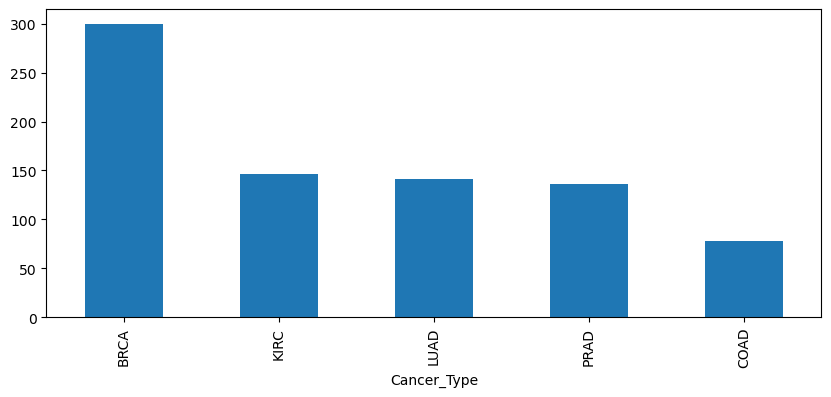

In [36]:
# let´s look at a bar chart to check class distribution (balance?)
cancer_df["Cancer_Type"].value_counts().plot(kind = "bar", figsize = (10,4))

Data preprocessing

In [42]:
# High fit proportion of Breast Cancer samples (overfit)
# Class imbalance - high proportion of 1 class with respect to the others
# Separate feature values from the class

X = cancer_df.iloc[:,0:-1] # supervised learning
Y = cancer_df.iloc[:,-1]

In [44]:
X.shape, Y.shape

((801, 8000), (801,))

In [46]:
# Code levels (0- n_classes - 1) - True or false predictions
# label_encoder -> need to change categorial cancer classes to numerical 

label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)

In [48]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [52]:
classes # arranged in alphabetical order

array([0, 1, 2, 3, 4])

Data Splitting 

In [54]:
# Training and test data splitting
# train the model -> td -> learn -> test data -> predict (data never seen before)
# Split data (80% = training, 20% = test)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 42)

In [60]:
cancer_df.iloc[:,0:10].describe() # descriptives (hmmm, normalising is needed!!)

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


Data Normalisation

In [64]:
# 0 - 1 scale -> avoid bias -> avoid overfitting of dominant class
# same scale for model predictions
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [72]:
print(type(X_train), type(X_test))
print(X_train.iloc[0:3], X_test.iloc[0:3])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
     gene_1    gene_2  gene_3    gene_4  gene_5    gene_6  gene_7  gene_8  \
616     0.0  0.000000     0.0  2.181643     0.0  0.913952     0.0     0.0   
329     0.0  1.002954     0.0  2.879569     0.0  0.000000     0.0     0.0   
342     0.0  0.000000     0.0  2.431543     0.0  0.000000     0.0     0.0   

       gene_9   gene_10  ...  gene_7991  gene_7992  gene_7993  gene_7994  \
616  0.000000  2.845831  ...   6.164583  11.978210   8.022717   5.912640   
329  0.000000  0.739330  ...   5.170714  11.612615   6.855516   3.327242   
342  1.301529  1.301529  ...   8.348458  11.421492   7.999386   7.061485   

     gene_7995  gene_7996  gene_7997  gene_7998  gene_7999  gene_8000  
616   6.439038  11.311311   6.631442   9.911364   7.942022   1.868884  
329   6.778445  11.909657   7.518936  10.342030   5.005719   0.416516  
342   7.065432  11.616668   7.737477  10.092242   7.395440   3.395310  

[3 rows x 8000 column

In [78]:
X_train_norm[0:3], X_test_norm[0:3] # good!

(array([[0.        , 0.        , 0.        , ..., 0.25369517, 0.74064352,
         0.19190747],
        [0.        , 0.15254052, 0.        , ..., 0.35669972, 0.43979635,
         0.04277014],
        [0.        , 0.        , 0.        , ..., 0.29695667, 0.68464193,
         0.34864934]]),
 array([[0.        , 0.19882157, 0.        , ..., 0.4638307 , 0.59985324,
         0.33150433],
        [0.        , 0.        , 0.        , ..., 0.40756754, 0.41138554,
         0.24020578],
        [0.        , 0.        , 0.        , ..., 0.53563946, 0.37521231,
         0.43947279]]))

Feature selection

In [80]:
# select relevant features for classification
# scores for each of the features (relevance of features) -> top "n" features

MI = mutual_info_classif(X_train_norm, y_train)

In [82]:
MI.shape

(8000,)

In [84]:
MI[0:4]

array([0.00371675, 0.04406334, 0.04316379, 0.05026605])

In [86]:
features = X_train.columns

In [88]:
features[0:4]

Index(['gene_1', 'gene_2', 'gene_3', 'gene_4'], dtype='object')

In [90]:
# select top n features (n = 300)
n_features = 300
selected_scores_indices = np.argsort(MI) [::-1] [0:n_features] # sort in desc -> select top n features

In [94]:
# use indices to select them
X_train_selected = X_train_norm[:,selected_scores_indices]
X_test_selected = X_test_norm[:, selected_scores_indices]

In [96]:
X_train_selected.shape, X_test_selected.shape # 300 features

((640, 300), (161, 300))

Classification (Random Forest)

In [ ]:
# RF classifier
# Tell that sample x = cancer_type(z)

Model Training

In [98]:
RF = OneVsRestClassifier(RandomForestClassifier(max_features = 0.2))
RF.fit(X_train_selected, y_train)
y_pred = RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

Model evaluation (accuracy, precision, recall, F1, confusion matrix, ROC curve)

In [100]:
# accuracy
accuracy = np.round(balanced_accuracy_score(y_test, y_pred), 4)
print("accuracy:%0.4f"%accuracy)

accuracy:0.9550


In [102]:
# precision
precision = np.round(precision_score(y_test, y_pred, average = "weighted"), 4)
print("precision:%0.4f"%precision)

precision:0.9695


In [104]:
# recall
recall = np.round(recall_score(y_test, y_pred, average = "weighted"), 4)
print("recall:%0.4f"%recall)

recall:0.9689


In [106]:
f1_score = np.round(f1_score(y_test, y_pred, average = "weighted"), 4)
print("f1 score:%0.4f"%f1_score)

f1 score:0.9687


In [108]:
report = classification_report(y_test, y_pred, target_names = labels)
print("\n")
print("classification report\n\n")
print(report)



classification report


              precision    recall  f1-score   support

        BRCA       0.95      0.98      0.97        60
        COAD       1.00      0.88      0.93        16
        KIRC       1.00      1.00      1.00        28
        LUAD       0.92      0.92      0.92        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.97       161
   macro avg       0.97      0.96      0.96       161
weighted avg       0.97      0.97      0.97       161



In [ ]:
# all approaching the value of 1 -> model performance = good!

In [110]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

In [114]:
cm_df # 59 predicted cases of BRC and  1 of LUAD
# missclassifications! #1 and #2

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,59,0,0,1,0
COAD,1,14,0,1,0
KIRC,0,0,28,0,0
LUAD,2,0,0,22,0
PRAD,0,0,0,0,33


Text(50.722222222222214, 0.5, 'True Function')

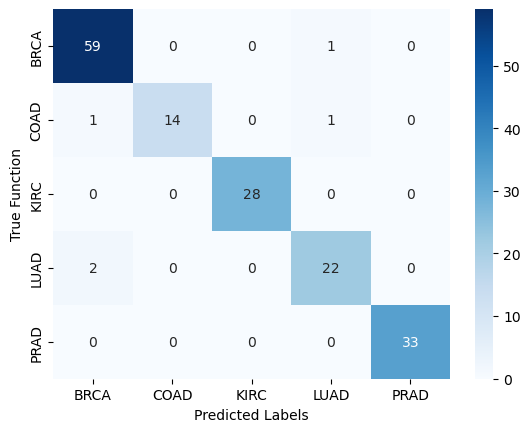

In [116]:
# visualise confusion matrix as a heatmap
sns.heatmap(cm_df, annot = True, cmap = "Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Function")

In [142]:
disp = plt_confusion_matrix(RF, X_test_selected, y_test, xticks_rotation = "vertical",
                             cmap = "Blues", display_labels = labels)

NameError: name 'plt_confusion_matrix' is not defined

In [144]:
pred_prob.shape

(161, 5)

In [146]:
y_pred.shape

(161,)

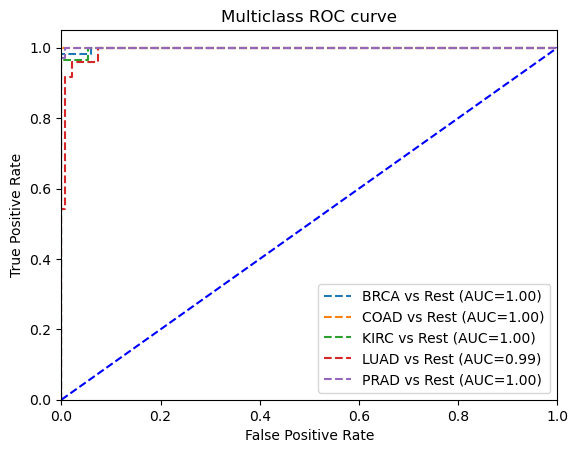

In [158]:
# roc curves per class
# visualise the performance of models
# binarise y_test labels
# need to put it in the same format as pred_prob
y_test_binarised = label_binarize(y_test, classes = classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarised[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # plot
    plt.plot(fpr[i], tpr[i], linestyle="--",
    label = "%s vs Rest (AUC=%0.2f)"%(labels[i], roc_auc[i]))

plt.plot([0,1], [0,1], "b--")
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title("Multiclass ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()